Loaded dataset: 862986 rows, 17 columns
After SMOTEENN: (779212, 29), Positives: 422723.0
Epoch 1/50
685/685 - 4s - 6ms/step - auc: 0.9123 - loss: 0.4431 - val_auc: 0.0000e+00 - val_loss: 0.3699
Epoch 2/50
685/685 - 3s - 4ms/step - auc: 0.9250 - loss: 0.3634 - val_auc: 0.0000e+00 - val_loss: 0.3638
Epoch 3/50
685/685 - 3s - 4ms/step - auc: 0.9261 - loss: 0.3537 - val_auc: 0.0000e+00 - val_loss: 0.3406
Epoch 4/50
685/685 - 3s - 4ms/step - auc: 0.9267 - loss: 0.3513 - val_auc: 0.0000e+00 - val_loss: 0.3653
Epoch 5/50
685/685 - 3s - 4ms/step - auc: 0.9272 - loss: 0.3499 - val_auc: 0.0000e+00 - val_loss: 0.3437
Epoch 6/50
685/685 - 3s - 4ms/step - auc: 0.9274 - loss: 0.3495 - val_auc: 0.0000e+00 - val_loss: 0.3557
Epoch 7/50
685/685 - 3s - 4ms/step - auc: 0.9279 - loss: 0.3487 - val_auc: 0.0000e+00 - val_loss: 0.3621
Epoch 8/50
685/685 - 3s - 4ms/step - auc: 0.9282 - loss: 0.3480 - val_auc: 0.0000e+00 - val_loss: 0.3555
Epoch 9/50
685/685 - 3s - 4ms/step - auc: 0.9285 - loss: 0.3474 - val_

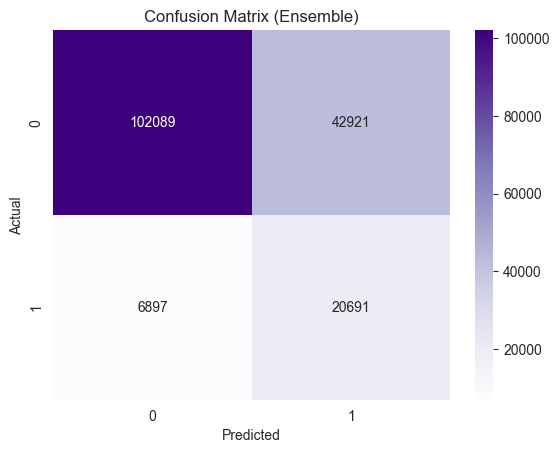

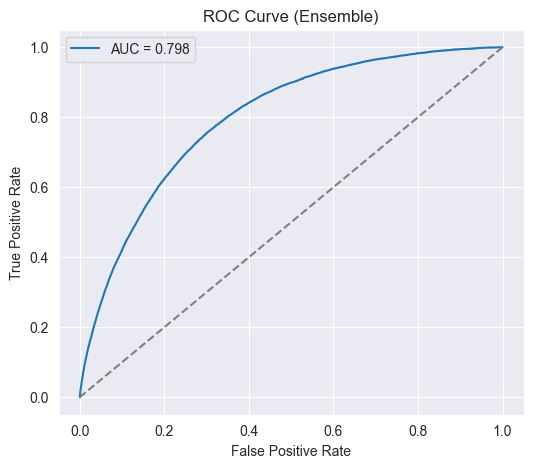

In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# CatBoost
from catboost import CatBoostClassifier, Pool

# -----------------------------
# Load and preprocess data
# -----------------------------
df = pd.read_csv("only2123.csv")
print(f"Loaded dataset: {df.shape[0]} rows, {df.shape[1]} columns")

# -----------------------------
# Missing value handling
# -----------------------------
df_proc = df.copy()
for col in df_proc.columns:
    if df_proc[col].isna().sum() > 0:
        df_proc[f"{col}_missing"] = df_proc[col].isna().astype(int)
        if df_proc[col].dtype == 'object':
            df_proc[col] = df_proc[col].fillna(df_proc[col].mode()[0])
        else:
            df_proc[col] = df_proc[col].fillna(df_proc[col].median())

# -----------------------------
# Encode categorical features
# -----------------------------
cat_cols = df_proc.select_dtypes(include=['object']).columns.tolist()
encoder = LabelEncoder()
for col in cat_cols:
    df_proc[col] = encoder.fit_transform(df_proc[col].astype(str))

# -----------------------------
# Feature engineering
# -----------------------------
if 'BMI' in df_proc.columns and 'Age' in df_proc.columns:
    df_proc['BMI_Age'] = df_proc['BMI'] * df_proc['Age']
if 'Glucose' in df_proc.columns and 'Insulin' in df_proc.columns:
    df_proc['Glucose_Insulin_ratio'] = df_proc['Glucose'] / (df_proc['Insulin'] + 1)

# -----------------------------
# Features & Target
# -----------------------------
target_col = 'diabetes'
X = df_proc.drop(columns=[target_col])
y = df_proc[target_col]

if 'year' in X.columns:
    X = X.drop(columns=['year'])

# Feature scaling for DL
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# SMOTEENN for balanced training
# -----------------------------
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X_train, y_train)
print(f"After SMOTEENN: {X_res.shape}, Positives: {sum(y_res)}")

# -----------------------------
# Deep Learning Model
# -----------------------------
def build_dl_model(input_dim):
    model = Sequential([
        Dense(128, input_shape=(input_dim,), kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.4),
        Dense(64, kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

dl_model = build_dl_model(X_res.shape[1])
history = dl_model.fit(
    X_res, y_res,
    validation_split=0.1,
    epochs=50,
    batch_size=1024,
    verbose=2
)

y_proba_dl = dl_model.predict(X_test).flatten()

# -----------------------------
# CatBoost Model
# -----------------------------
cat_model = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.05,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    class_weights=[1,4]  # more balanced to improve precision
)
train_pool = Pool(X_res, y_res)
cat_model.fit(train_pool, verbose=100)
y_proba_cb = cat_model.predict_proba(X_test)[:,1]

# -----------------------------
# Ensemble (Stacking / Weighted Average)
# -----------------------------
# Weighted average leaning more on CatBoost for precision
y_proba_ensemble = 0.3*y_proba_dl + 0.7*y_proba_cb

# Threshold tuning for precision-recall balance
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_ensemble)
target_recall = 0.75  # keep recall around 0.75
idx = np.argmin(np.abs(recalls - target_recall))
best_thr = thresholds[idx]
y_pred_ensemble = (y_proba_ensemble >= best_thr).astype(int)

# -----------------------------
# Evaluation
# -----------------------------
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble, digits=3))

roc_auc = roc_auc_score(y_test, y_proba_ensemble)
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix (Ensemble)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_ensemble)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.legend()
plt.title("ROC Curve (Ensemble)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
